In [1]:
from utils import top_anomalous, top_mean_anomalous, errorbar_classification
from util import tile_tv_images

from variational_autoencoder import VariationalAutoEncoder
from verification_net import VerificationNet
from model_trainer import ModelTrainer
from stacked_mnist import StackedMNIST, DataMode

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("mps")
torch.mps.set_per_process_memory_fraction(0.)

trainer_file = Path("trainers/vae-anom.pkl")
model_file = Path("models/vae-anom")

In [3]:
class VariationalAutoEncoderTrainer(ModelTrainer):
    def __init__(
            self, 
            model, 
            loss, 
            optimizer,
            device = torch.device("mps"),
            file_name: str | Path = model_file, 
            force_learn: bool = False
        ) -> None:
        super().__init__(model, loss, optimizer, device, file_name, force_learn)

    def get_output_from_batch(self, batch):
        x, _, _ = batch
        x = x.to(self.device)
        (mu, log_var), x_hat = self.model(x)
        return (x_hat, x), (mu, log_var)

In [4]:
VAE = VariationalAutoEncoder()

In [5]:
def loss(X, params):
    x_hat, x = X
    mu, log_var = params
    BCE = F.binary_cross_entropy(x_hat, x, reduction='mean')
    KLD = torch.mean(- 0.5 * torch.mean(1 + log_var - mu.pow(2) - torch.exp(log_var), axis=1))

    return BCE + .02 * KLD

In [6]:
opt = optim.Adam(VAE.parameters(), lr=1e-6)

In [7]:
Trainer = VariationalAutoEncoderTrainer(
        model=VAE, 
        loss=loss, 
        optimizer=opt, 
        file_name=model_file,
        force_learn=False
    )

In [8]:
mode = DataMode.MONO | DataMode.BINARY

In [9]:
trainset = StackedMNIST(train=True, mode=mode | DataMode.MISSING)
testset = StackedMNIST(train=False, mode=mode)

/Users/arthurtestard/envs/ntnu/deeplearning/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [10]:
batch_size = 1
data = DataLoader(trainset, shuffle=True, batch_size=batch_size)
x, _, labels = next(iter(data))

In [11]:
Trainer.optimizer = optim.Adam(VAE.parameters(), lr=5e-4)

In [12]:
Trainer.train(
        trainset=trainset, 
        valset=testset, 
        epochs=100, 
        batch_size=2048
    )

In [39]:
Trainer.load_trainer(trainer_file=trainer_file)

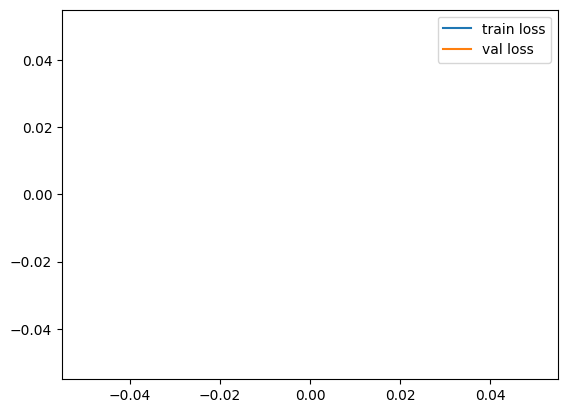

In [40]:
plt.plot(Trainer.losses, label="train loss")
plt.plot(Trainer.val_losses, label="val loss")
plt.legend()

In [15]:
train_loader = DataLoader(dataset=trainset, shuffle=True, batch_size=2048)
test_loader = DataLoader(dataset=testset, shuffle=True, batch_size=2048)

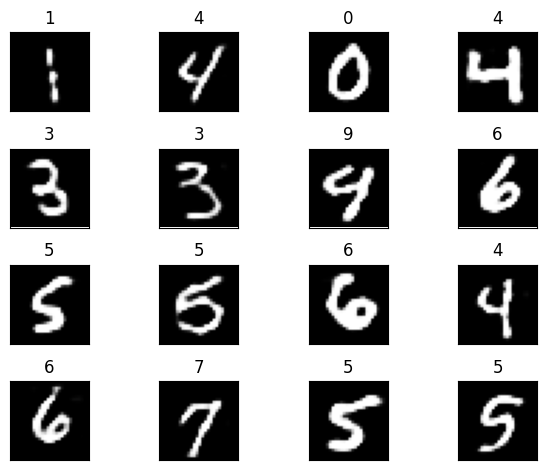

In [20]:
Trainer.print_reconstructed_img(trainset, batch_size=16)

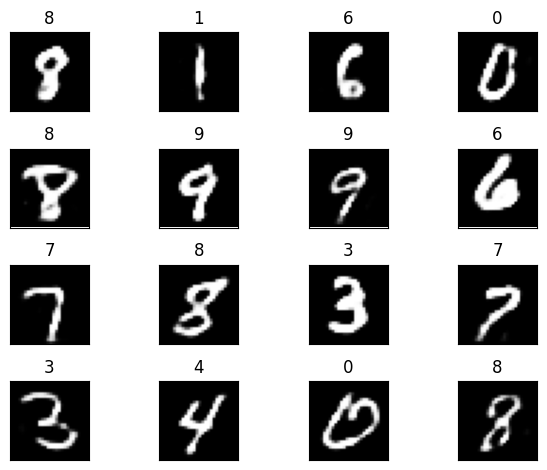

In [21]:
Trainer.print_reconstructed_img(testset, batch_size=16)

In [22]:
VerifNet = VerificationNet(force_learn=False, file_name='models/verification_model_torch_ok_copy')

In [23]:
Trainer.print_class_coverage_and_predictability(VerifNet, trainset, batch_size=10_000)

Coverage: 100.00%
Predictability: 99.25%
Accuracy: 96.79%


In [25]:
Trainer.print_class_coverage_and_predictability(VerifNet, testset, batch_size=10_000)

Coverage: 100.00%
Predictability: 98.85%
Accuracy: 95.21%


In [28]:
data = DataLoader(testset, shuffle=True, batch_size=10000)
imgs, _, labels = next(iter(data))

labels = labels.detach().numpy()
imgs = imgs.to(device)
_, preds = VAE(imgs)

In [29]:
nb_samples = 100

In [30]:
from tqdm import tqdm
class_accuracies = [[] for _ in range(10)]
probas = []
for x, label in tqdm(zip(imgs, labels)):
    x = x.view(1, 1, 28, 28)
    mu, log_var = VAE.encoder(x)

    std = torch.sqrt(torch.exp(log_var)).to(device)
    eps = torch.randn_like(std.expand(nb_samples,64)).to(device)
    z = mu + eps * std
    x_hat = VAE.decoder(z)

    x = x.expand(nb_samples, 1, 28, 28)
    class_accuracies[label].append((-F.binary_cross_entropy(x_hat, x)).exp().mean().cpu().detach().numpy())
    probas.append((-F.binary_cross_entropy(x_hat, x)).exp().mean().cpu().detach().numpy())
    
mean_accuracy = [np.mean(acc) for acc in class_accuracies]
std_accuracy = [np.std(acc) for acc in class_accuracies]

probas = np.array(probas)

10000it [02:13, 75.15it/s]


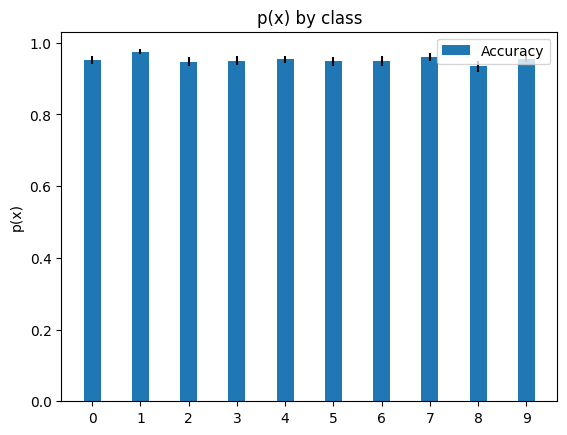

In [31]:
errorbar_classification(np.arange(10), mean_accuracy=mean_accuracy, std_accuracy=std_accuracy, label="p(x)")


In [32]:
def top_anomalous_vae(k, losses, preds, labels, is_bottom = True):
    idx = np.argsort(losses)[:k] if is_bottom else np.flip(np.argsort(losses))[:k]

    new_labels = [ 
        str(f"p(x={labels[_id]}): {int(losses[_id] * 1e2) / 1e2}") for _id in idx
        ]
    tile_tv_images(images=preds[idx], labels=new_labels)

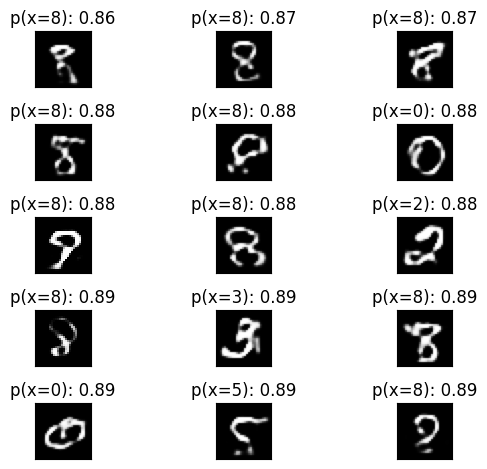

In [33]:
top_anomalous_vae(15, probas, preds.cpu().detach().numpy().reshape(-1, 28, 28), labels)

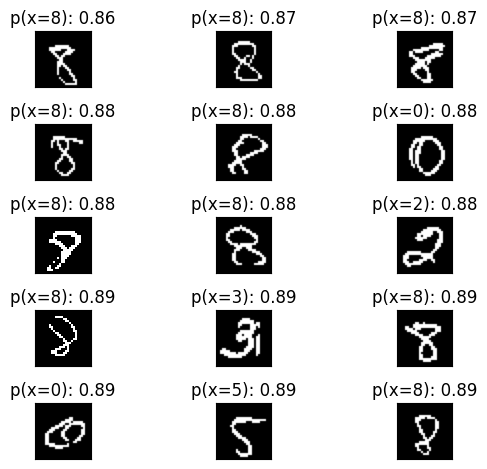

In [34]:
top_anomalous_vae(15, probas, imgs.cpu().detach().numpy().reshape(-1, 28, 28), labels)

(<Figure size 640x480 with 9 Axes>,
 array([[<Axes: title={'center': 'p(x=8) = 9.341e-1'}>,
         <Axes: title={'center': 'p(x=2) = 9.469e-1'}>,
         <Axes: title={'center': 'p(x=5) = 9.477e-1'}>],
        [<Axes: title={'center': 'p(x=6) = 9.493e-1'}>,
         <Axes: title={'center': 'p(x=3) = 9.504e-1'}>,
         <Axes: title={'center': 'p(x=0) = 9.511e-1'}>],
        [<Axes: title={'center': 'p(x=4) = 9.542e-1'}>,
         <Axes: title={'center': 'p(x=9) = 9.557e-1'}>,
         <Axes: title={'center': 'p(x=7) = 9.597e-1'}>]], dtype=object))

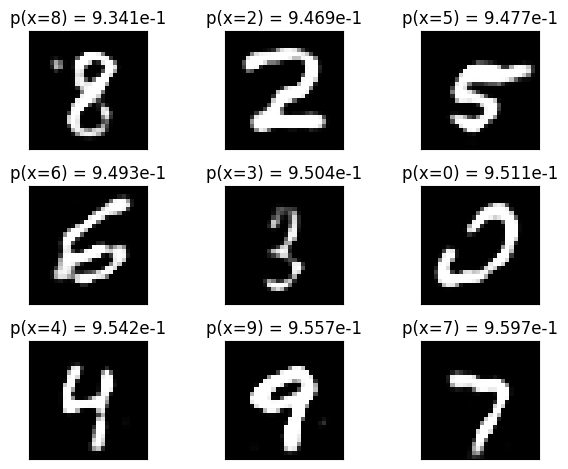

In [38]:
x_values = np.argsort(mean_accuracy)[:9]
is_color = preds.shape[1] == 3

new_labels = [ 
    str(f"p(x={x_value}) = {int(mean_accuracy[x_value] * 1e4) / 1e3}e-1") for x_value in x_values
    ]
np_imgs_predicted = preds.reshape(-1, 28, 28).cpu().detach().numpy() if not is_color else preds.permute(0,2,3,1).cpu().detach().numpy()

anomalies_pred = np.array([ np_imgs_predicted[np.argwhere(labels == x_value)[:,0]][0] for x_value in x_values ])

tile_tv_images(images=anomalies_pred, labels=new_labels)
